# For each meter away from the subway station how does the price vary

In [1]:
import statsmodels
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import seaborn as sns 
from scipy import stats
import contextily as cx

## Cleaning datasets

In [2]:
anjuke = pd.read_pickle('utseus-anjuke-real-estate.pk')
anjuke_df = pd.DataFrame(anjuke[1:], columns=anjuke[0])
anjuke_df.head()

,id,address,longitude,latitude,bedroom,room,surface,price,onesquaremeter,tags,district,neighborhood,done
0,A888553302,宝山-大场 金地艺境(宝山)(555弄),121.34392735101,31.3193561718426,2,2,30.0,1160000.0,38666.6666666667,金地开发 **首推 地铁首通 价格首降 配套就是你能想到的,baoshan,dachang,1
1,A888376847,宝山-大场 骏华苑,121.407324884273,31.3023675431043,1,1,38.0,1950000.0,51315.7894736842,龙璟公馆嘉兴市近万达广场，北大附属实验校区，地铁沿线高铁站旁,baoshan,dachang,1
2,A885088482,宝山-大场 琉樽尚品(255弄),121.397487377268,31.2908711986862,3,2,92.0,5350000.0,58152.1739130435,92+7平书房，婚房装修30万！满2年税少11万！再降20万,baoshan,dachang,1
3,A885392981,宝山-大场 琉樽尚品（255弄）,121.397487377268,31.2908711986862,2,2,68.0,4350000.0,63970.5882352941,中环景观，电梯复式，豪装45万全送，拎包入住，小格局大设计，,baoshan,dachang,1
4,A885831305,宝山-大场 美好家小区,121.421397234518,31.302658471085,2,2,80.0,4000000.0,50000.0,美好家南北通精装2房板式房型采光好随时好看带天井,baoshan,dachang,1


In [3]:
anjuke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467029 entries, 0 to 467028
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              467029 non-null  object
 1   address         467029 non-null  object
 2   longitude       467029 non-null  object
 3   latitude        467029 non-null  object
 4   bedroom         467029 non-null  object
 5   room            467029 non-null  object
 6   surface         467029 non-null  object
 7   price           467029 non-null  object
 8   onesquaremeter  467029 non-null  object
 9   tags            467029 non-null  object
 10  district        467029 non-null  object
 11  neighborhood    467029 non-null  object
 12  done            467029 non-null  object
dtypes: object(13)
memory usage: 46.3+ MB


In [3]:
# anjuke_df["longitude"] = pd.to_numeric(anjuke_df["longitude"])
# anjuke_df["latitude"] = pd.to_numeric(anjuke_df["latitude"])
# anjuke_df["price"] = pd.to_numeric(anjuke_df["price"])
# anjuke_df["onesquaremeter"] = pd.to_numeric(anjuke_df["onesquaremeter"])
anjuke_df["id"] = anjuke_df["id"].astype("string")

anjuke_df[['longitude', 'latitude', 'bedroom', 'room', 'surface',
       'price', 'onesquaremeter']] = anjuke_df[['longitude', 'latitude', 'bedroom', 'room', 'surface',
       'price', 'onesquaremeter']].apply(pd.to_numeric)
anjuke_df.dropna(inplace=True) # alternative to: anjuke_df = anjuke_df.dropna(inplace=True)
anjuke_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 463067 entries, 0 to 467028
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              463067 non-null  string 
 1   address         463067 non-null  object 
 2   longitude       463067 non-null  float64
 3   latitude        463067 non-null  float64
 4   bedroom         463067 non-null  int64  
 5   room            463067 non-null  int64  
 6   surface         463067 non-null  float64
 7   price           463067 non-null  float64
 8   onesquaremeter  463067 non-null  float64
 9   tags            463067 non-null  object 
 10  district        463067 non-null  object 
 11  neighborhood    463067 non-null  object 
 12  done            463067 non-null  object 
dtypes: float64(5), int64(2), object(5), string(1)
memory usage: 49.5+ MB


In [4]:
df_POI = pd.read_csv('shanghaiPOI2017.csv',delimiter=';',decimal=',')
df_POI #we need to use GPS coordinate

/tmp/ipykernel_181/2327343557.py:1: DtypeWarning: Columns (7,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_POI = pd.read_csv('shanghaiPOI2017.csv',delimiter=';',decimal=',')


,Unnamed: 0,ID,POIID,GCJX,GCJY,NAME,ADD,TEL,TYPE,AREAID,...,TYPE5,TYPE3.1,TYPE3.2,TYPE3.3,TYPE1.N,TYPE2.N,TYPE3.N,TYPE3.1.N,TYPECODE,GBCODE
0,1,1,B0FFFROHL9,121.300848,31.186326,2015年中国国际纱线(春夏)展览会,崧泽大道333号国家会展中心内,NaN,事件活动;事件活动;事件活动,310118,...,NaN,事件活动,NaN,NaN,59,4,4,4,事件活动;事件活动;事件活动,990000.0
1,2,1,B0FFFSUKZ2,121.477869,31.226968,勃兰登堡之声-2015家庭音乐会,金陵中路88号森海塞尔上海音乐厅内,021-53866666;021-63862836,事件活动;事件活动;事件活动,310101,...,NaN,事件活动,NaN,NaN,59,4,4,4,事件活动;事件活动;事件活动,990000.0
2,3,1,B0FFFWQXS0,121.404027,31.203180,2015第十四届(上海)国际有机食品和绿色食品博览会,兴义路77号上海国际展览中心内,021-62755800,事件活动;事件活动;事件活动,310105,...,NaN,事件活动,NaN,NaN,59,4,4,4,事件活动;事件活动;事件活动,990000.0
3,4,1,B0FFGRFTZ1,121.533945,31.268965,星星火炬上海组委会,长阳路1616号互联网教育大厦6层,021-80103718;021-80103719,事件活动;事件活动;事件活动,310110,...,NaN,事件活动,NaN,NaN,59,4,4,4,事件活动;事件活动;事件活动,990000.0
4,5,2,B0FFHC66BA,121.173709,31.280421,2016VGT国际铁人三项赛,安亭镇博园路7575号上海汽车博览公园内,NaN,事件活动;公众活动;体育赛事,310114,...,NaN,体育赛事,NaN,NaN,59,55,2,2,事件活动;公众活动;体育赛事,990000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738247,1738248,3307,B0FFF6XJQM,121.452594,31.274073,美珍香(大宁国际商业广场6座),共和新路2008号F1层F112,021-56433977,餐饮服务;餐饮相关场所;餐饮相关|购物服务;购物相关场所;购物相关场所,310106,...,购物相关场所,餐饮相关,购物服务,NaN,227757,47736,7,47736,餐饮服务;餐饮相关场所;餐饮相关|购物服务;购物相关场所;购物相关场所,139900.0
1738248,1738249,3307,B0FFG88J5W,121.158545,31.295163,俄罗斯美食(保真东北特产),安亭镇昌吉路241号,18321003796,餐饮服务;餐饮相关场所;餐饮相关|购物服务;购物相关场所;购物相关场所,310114,...,购物相关场所,餐饮相关,购物服务,NaN,227757,47736,7,47736,餐饮服务;餐饮相关场所;餐饮相关|购物服务;购物相关场所;购物相关场所,139900.0
1738249,1738250,3307,B0FFG8UAO4,121.397847,31.156591,东兰冷饮批发,东兰路320号东兰购物广场1层,13024178499,餐饮服务;餐饮相关场所;餐饮相关|购物服务;购物相关场所;购物相关场所,310112,...,购物相关场所,餐饮相关,购物服务,NaN,227757,47736,7,47736,餐饮服务;餐饮相关场所;餐饮相关|购物服务;购物相关场所;购物相关场所,139900.0
1738250,1738251,3307,B0FFGFFPDL,121.055244,31.110455,鑫和,北大街251号,NaN,餐饮服务;餐饮相关场所;餐饮相关|购物服务;购物相关场所;购物相关场所,310118,...,购物相关场所,餐饮相关,购物服务,NaN,227757,47736,7,47736,餐饮服务;餐饮相关场所;餐饮相关|购物服务;购物相关场所;购物相关场所,139900.0


In [5]:
df_POI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1738252 entries, 0 to 1738251
Data columns (total 27 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   ID          int64  
 2   POIID       object 
 3   GCJX        float64
 4   GCJY        float64
 5   NAME        object 
 6   ADD         object 
 7   TEL         object 
 8   TYPE        object 
 9   AREAID      int64  
 10  IDKEY       float64
 11  GPSX        float64
 12  GPSY        float64
 13  TYPE1       object 
 14  TYPE2       object 
 15  TYPE3       object 
 16  TYPE4       object 
 17  TYPE5       object 
 18  TYPE3.1     object 
 19  TYPE3.2     object 
 20  TYPE3.3     float64
 21  TYPE1.N     int64  
 22  TYPE2.N     int64  
 23  TYPE3.N     int64  
 24  TYPE3.1.N   int64  
 25  TYPECODE    object 
 26  GBCODE      float64
dtypes: float64(7), int64(7), object(13)
memory usage: 358.1+ MB


In [6]:
df_POI = df_POI[df_POI.TYPECODE.str.contains('地铁')] # keep only subwaystations
df_POI[["ID","POIID","GPSX","GPSY","GBCODE"]]

,ID,POIID,GPSX,GPSY,GBCODE
69644,44,BX10019657,121.314403,31.195826,200402.0
69645,44,BX10019658,121.313594,31.196116,200402.0
69646,44,BX10019659,121.315250,31.195877,200402.0
69647,44,BX10019717,121.343555,31.156297,200402.0
69648,44,BX10019718,121.228284,31.056276,200402.0
...,...,...,...,...,...
71345,45,BV10040000,121.411954,31.028432,200401.0
71346,45,BV10040001,121.405555,31.013236,200401.0
71347,45,BV10040002,121.390624,31.009423,200401.0
71348,45,BV10040003,121.376154,31.005564,200401.0


## anjuke MAP

In [7]:
anjuke_df = anjuke_df[anjuke_df.longitude >= 121.10157]
anjuke_df = anjuke_df[anjuke_df.longitude <= 121.804611]

anjuke_df = anjuke_df[anjuke_df.latitude >= 30.975]
anjuke_df = anjuke_df[anjuke_df.latitude <= 31.514999]

anjuke_gdf = gpd.GeoDataFrame(
    anjuke_df,
    geometry=gpd.points_from_xy(anjuke_df.longitude,anjuke_df.latitude)
)

<AxesSubplot:>

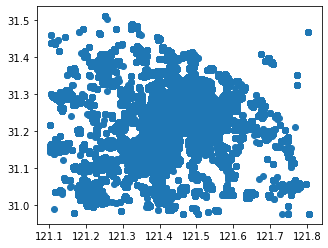

In [8]:
anjuke_gdf.plot() 

SSLError: HTTPSConnectionPool(host='a.tile.openstreetmap.fr', port=443): Max retries exceeded with url: /hot/10/858/418.png (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1007)')))

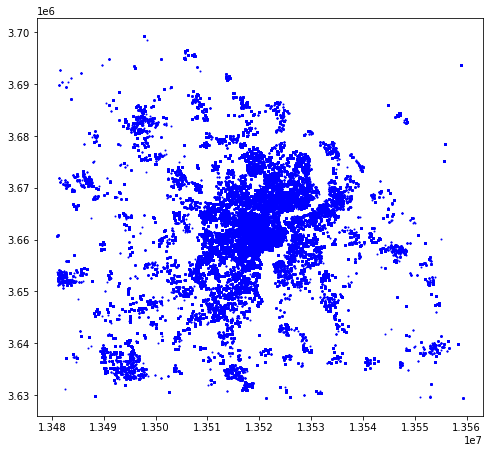

In [10]:
anjuke_gdf = gpd.GeoDataFrame(
    anjuke_df,
    geometry=gpd.points_from_xy(anjuke_df.longitude,anjuke_df.latitude, crs = 4326)
)

ax = anjuke_gdf.to_crs(3857).plot(markersize=1,color='b', figsize=(8,8)) # to_crs because the map use 3857 crs
cx.add_basemap(ax)


## POI MAP

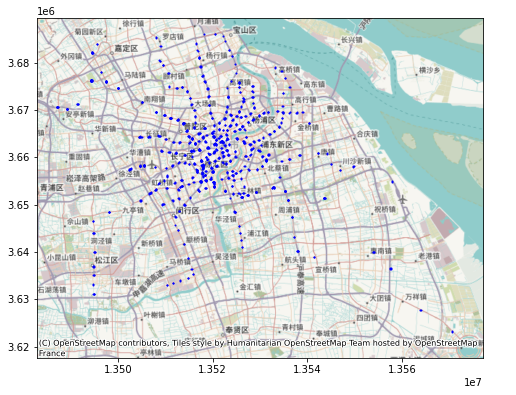

In [11]:
df_POI = df_POI[df_POI.GBCODE == 200402] # subway station have 200402 as GBCODE
POI_gdf = gpd.GeoDataFrame(
    df_POI,
    geometry=gpd.points_from_xy(df_POI.GPSX,df_POI.GPSY, crs = 4326)
)

ax = POI_gdf.to_crs(3857).plot(markersize=1,color='b', figsize=(8,8)) # to_crs because the map use 3857 crs
cx.add_basemap(ax)

## Convert into meters

In [12]:
anjuke_filtershp_gdf = anjuke_gdf.to_crs(4576)
poi_subway_gdf = POI_gdf.to_crs(4576)

In [13]:
anjuke_filtershp_gdf.sample(2).geometry

369834    POINT (21356811.201 3457928.341)
197789    POINT (21331000.839 3457687.225)
Name: geometry, dtype: geometry

## distance between appartements & POI

In [14]:
%%time

x = poi_subway_gdf.geometry.x
y = poi_subway_gdf.geometry.y
subway_points = np.array(list(zip(x,y)))


x = anjuke_filtershp_gdf.geometry.x
y = anjuke_filtershp_gdf.geometry.y
anjuke_points = np.array(list(zip(x,y)))

tree = BallTree(subway_points, leaf_size=2, metric='euclidean')
anjuke_filtershp_gdf['nearest_sklearn'], _ = tree.query(anjuke_points, k=1)

CPU times: user 1.35 s, sys: 30.3 ms, total: 1.38 s
Wall time: 1.37 s


In [15]:
anjuke_filtershp_gdf

,id,address,longitude,latitude,bedroom,room,surface,price,onesquaremeter,tags,district,neighborhood,done,geometry,nearest_sklearn
0,A888553302,宝山-大场 金地艺境(宝山)(555弄),121.343927,31.319356,2,2,30.0,1160000.0,38666.666667,金地开发 **首推 地铁首通 价格首降 配套就是你能想到的,baoshan,dachang,1,POINT (21342354.732 3467628.095),2415.370209
1,A888376847,宝山-大场 骏华苑,121.407325,31.302368,1,1,38.0,1950000.0,51315.789474,龙璟公馆嘉兴市近万达广场，北大附属实验校区，地铁沿线高铁站旁,baoshan,dachang,1,POINT (21348363.197 3465655.143),302.693414
2,A885088482,宝山-大场 琉樽尚品(255弄),121.397487,31.290871,3,2,92.0,5350000.0,58152.173913,92+7平书房，婚房装修30万！满2年税少11万！再降20万,baoshan,dachang,1,POINT (21347407.938 3464393.810),1401.605767
3,A885392981,宝山-大场 琉樽尚品（255弄）,121.397487,31.290871,2,2,68.0,4350000.0,63970.588235,中环景观，电梯复式，豪装45万全送，拎包入住，小格局大设计，,baoshan,dachang,1,POINT (21347407.938 3464393.810),1401.605767
4,A885831305,宝山-大场 美好家小区,121.421397,31.302658,2,2,80.0,4000000.0,50000.000000,美好家南北通精装2房板式房型采光好随时好看带天井,baoshan,dachang,1,POINT (21349703.629 3465668.134),1151.838851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467024,A900395782,闵行-颛桥 金铭新水岸,121.396319,31.070102,4,2,133.0,7950000.0,59774.436090,金铭新水岸 四房朝南 南北通透 户型极好 中心位置,minhang,zhuanqiao,1,POINT (21346941.768 3439913.221),139.711416
467025,A894201659,闵行-颛桥 君莲宏润丽苑,121.409855,31.086274,3,2,106.0,4500000.0,42452.830189,宏润丽园，南北通三房，精装修，景观楼层10楼，房东降价急卖,minhang,zhuanqiao,1,POINT (21348259.575 3441688.067),2250.136877
467026,A889222766,闵行-颛桥 招商雍华苑(公寓),121.403063,31.076927,1,2,74.0,4100000.0,55405.405405,招商洋房带电梯房税少 小户型 精装修 全南采光好随时看房！,minhang,zhuanqiao,1,POINT (21347596.428 3440660.777),1027.404984
467027,A855804105,闵行-颛桥 众众德尚世嘉,121.396942,31.075656,2,1,81.0,4500000.0,55555.555556,众众德尚世嘉 81平 425万 位置安静楼层好 靠近万达,minhang,zhuanqiao,1,POINT (21347010.213 3440528.329),728.529792


## Regression

In [16]:
import statsmodels.formula.api as smf

<AxesSubplot:xlabel='nearest_sklearn', ylabel='onesquaremeter'>

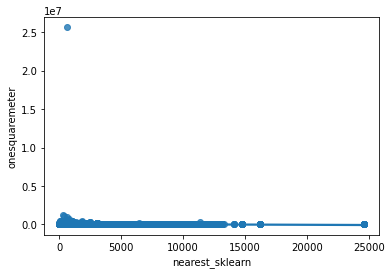

In [17]:
sns.regplot(data=anjuke_filtershp_gdf, x='nearest_sklearn', y='onesquaremeter')

In [18]:
anjuke_filtershp_gdf.onesquaremeter.describe()

count    3.923830e+05
mean     6.263487e+04
std      4.971727e+04
min      7.692308e+02
25%      4.383562e+04
50%      5.916667e+04
75%      7.739130e+04
max      2.564077e+07
Name: onesquaremeter, dtype: float64

In [19]:
med = anjuke_filtershp_gdf.onesquaremeter.median()
std = anjuke_filtershp_gdf.onesquaremeter.std()

In [20]:
# Remove outliers
anjuke_filtershp_gdf = anjuke_filtershp_gdf[anjuke_filtershp_gdf.onesquaremeter <= med + 3*std]
anjuke_filtershp_gdf = anjuke_filtershp_gdf[anjuke_filtershp_gdf.onesquaremeter >= med - 3*std]

<AxesSubplot:xlabel='nearest_sklearn', ylabel='onesquaremeter'>

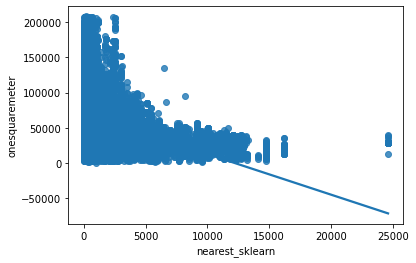

In [21]:
sns.regplot(data=anjuke_filtershp_gdf, x='nearest_sklearn', y='onesquaremeter')

### find B1 & B0 

In [28]:
distance_mean = anjuke_filtershp_gdf.nearest_sklearn.mean()
price_mean = anjuke_filtershp_gdf.onesquaremeter.mean()

numerator = np.sum((anjuke_filtershp_gdf.nearest_sklearn - distance_mean) * (anjuke_filtershp_gdf.onesquaremeter - price_mean))
denominator = np.sum((anjuke_filtershp_gdf.nearest_sklearn - distance_mean)**2)
B1 = numerator / denominator


B0 = price_mean - B1 * distance_mean

print(f"B1 = {B1}")
print(f"B0 = {B0}")

B1 = -5.763816875825253
B0 = 70479.72700837358


### 

### find r, t, p-value & residuals

In [22]:
from scipy.stats import t

In [24]:
r_squared = (anjuke_filtershp_gdf[['nearest_sklearn','onesquaremeter']].corr()['nearest_sklearn']['onesquaremeter'])**2
r_squared

0.19513815797214762

In [35]:
residuals = anjuke_filtershp_gdf["nearest_sklearn"].apply(lambda x : B1*x + B0) - anjuke_filtershp_gdf["onesquaremeter"]
n = len(residuals)
residuals = residuals.std() / anjuke_filtershp_gdf.nearest_sklearn.std() / (n-2)**0.5
residuals

0.018697680419999422

In [37]:
t_value = B1/residuals
t_value

-308.2637389427277

In [38]:
p_value = t.sf(np.abs(t_value), n-1)
p_value

0.0

## Using ols model

In [58]:
model = smf.ols(formula = "onesquaremeter ~ nearest_sklearn",data = anjuke_filtershp_gdf)

In [59]:
model = model.fit()

In [60]:
model.params

Intercept          70479.727008
nearest_sklearn       -5.763817
dtype: float64

In [34]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4901.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:55:40   Log-Likelihood:            -6.9858e+06
No. Observations:              392383   AIC:                         1.397e+07
Df Residuals:                  392381   BIC:                         1.397e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        8.456e+06   2.51e+04    336.403      0.000    8.41e+06    8.51e+06
nearest_sklearn  -696.7765      9.953    -70.006      0.000    -716.284    -677.269
==============================================================================
Omnibus:                   883725.685   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      13936522207.259
Skew:                          21.047   Prob(JB):                         0.00
Kurtosis:                     925.308   Cond. No.                     3.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
model.rsquared

0.05995319669860388